##### This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
# importing all the required Libraries
from collections import Counter
import cv2
import glob
import skimage
import numpy as np
import pandas as pd
import seaborn as sn
from tqdm import tqdm
from os import listdir
import matplotlib.pyplot as plt
from skimage.transform import resize
from collections import Counter
import warnings
warnings.filterwarnings("ignore")
import itertools
sn.set()

from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
from time import time

from sklearn import metrics
from sklearn.utils import shuffle
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score,f1_score,recall_score,cohen_kappa_score,precision_score, roc_curve
from sklearn.utils import compute_class_weight
from sklearn.preprocessing import MinMaxScaler,LabelBinarizer, LabelEncoder
# from sklearn.neighbors import KNeighborsClassifier # KNeighborsClassifier
# from sklearn.svm import SVC # SVM
# from sklearn.ensemble import RandomForestClassifier # RandomForestClassifier
# from sklearn.ensemble import AdaBoostClassifier # AdaBoostClassifier
# from xgboost import XGBClassifier # XGBClassifier
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam, Adamax, SGD

import tensorflow 
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.metrics import AUC
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model, Sequential
# from tensorflow.keras.applications.vgg16 import VGG16 # VGG16
# from tensorflow.keras.applications.vgg19 import VGG19 # VGG19
# from tensorflow.keras.applications.resnet50 import ResNet50 # ResNet50
# from tensorflow.keras.applications import ResNet101 # ResNet 101
from tensorflow.keras.applications.xception import Xception # Xception
# from tensorflow.keras.applications.mobilenet import MobileNet # MobileNet
# from tensorflow.keras.applications.densenet import DenseNet169 # DenseNet169
# from tensorflow.keras.applications.densenet import DenseNet121 # DenseNet121
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2 # MobileNetV2
# from tensorflow.keras.applications.inception_resnet_v2 import inception_resnet_v2

# from tensorflow.keras.applications.inception_v3 import InceptionV3 # InceptionV3
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, Flatten, Activation, GlobalAveragePooling2D,Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import os
from PIL import Image

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
def plot_img(path, set_):
    """
    takes the path and label and plots images of the given label
    """
    dir_ = os.path.join(path, 'train', set_)
    k = 0
    fig, ax = plt.subplots(3,3, figsize=(10,10))
    fig.suptitle(set_ + 'Faces')
    for j in range(3):
        for i in range(3):
            img = image.load_img(os.path.join(dir_, os.listdir(os.path.join(dir_))[k]))          
            ax[j,i].imshow(img)
            ax[j,i].set_title("")
            ax[j,i].axis('off')
            k +=1
  #  fig.tight_layout()
    plt.suptitle(set_ + ' faces')
    return plt.show()



In [4]:
path = '../input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake'


## Count images

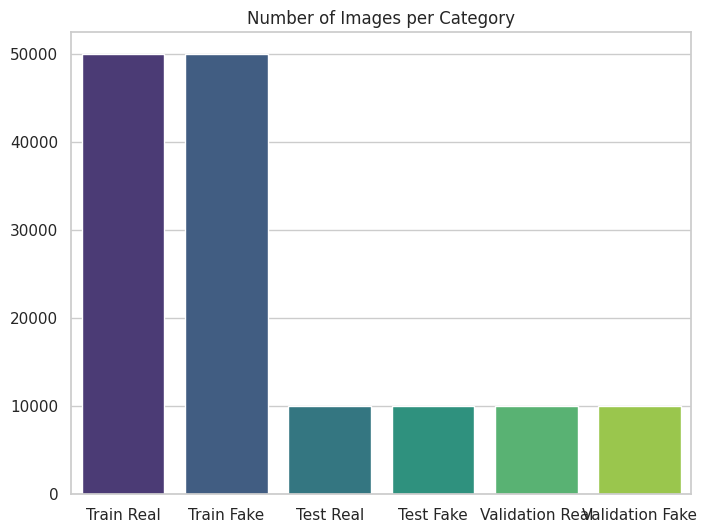

count_train_real_imgs=50000, count_train_fake_imgs=50000, count_test_real_imgs=10000, count_test_fake_imgs=10000


In [5]:
count_train_real_imgs = len([f for f in os.listdir(os.path.join(path, 'train', 'real'))])
count_train_fake_imgs = len([f for f in os.listdir(os.path.join(path, 'train', 'fake'))])
count_test_real_imgs = len([f for f in os.listdir(os.path.join(path, 'test', 'real'))])
count_test_fake_imgs = len([f for f in os.listdir(os.path.join(path, 'test', 'fake'))])
count_validation_real_imgs = len([f for f in os.listdir(os.path.join(path, 'valid', 'real'))])
count_validation_fake_imgs = len([f for f in os.listdir(os.path.join(path, 'valid', 'fake'))])

# Prepare the data for plotting
data = {
    'Category': ['Train Real', 'Train Fake', 'Test Real', 'Test Fake', 'Validation Real', 'Validation Fake'],
    'Count': [count_train_real_imgs, count_train_fake_imgs, count_test_real_imgs, count_test_fake_imgs, count_validation_real_imgs, count_validation_fake_imgs]
}

# Create a bar plot using Seaborn
sn.set(style="whitegrid")
plt.figure(figsize=(8, 6))
ax = sn.barplot(x='Category', y='Count', data=data, palette='viridis')
ax.set_title('Number of Images per Category')
plt.show()
# Printing the data
print(f"{count_train_real_imgs=}, {count_train_fake_imgs=}, {count_test_real_imgs=}, {count_test_fake_imgs=}")

## Real Images

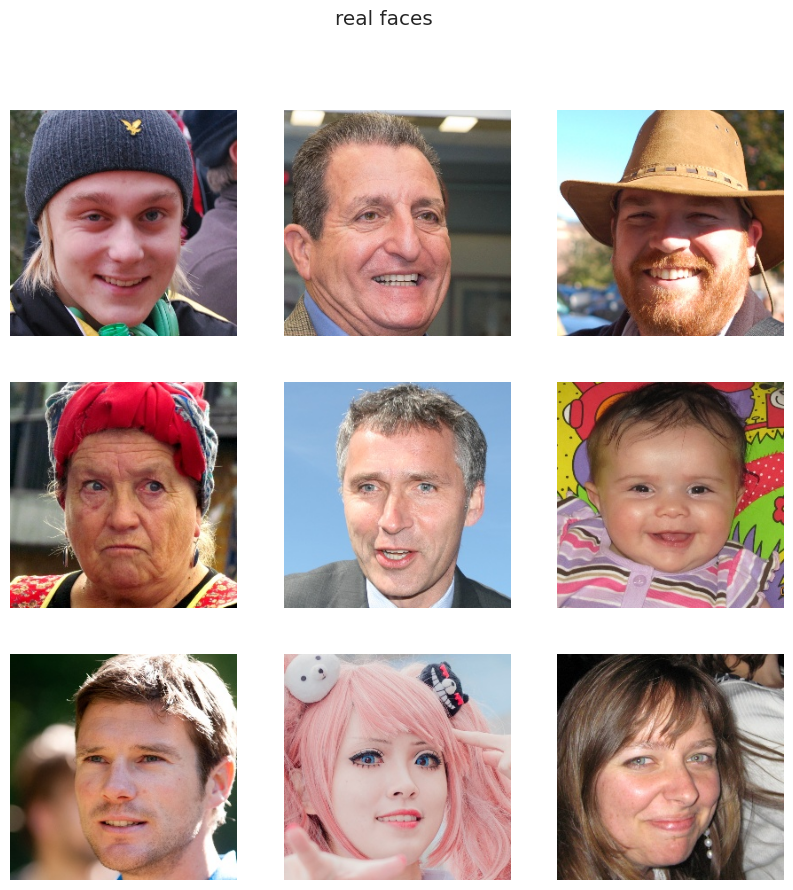

In [6]:
plot_img(path, 'real')

## Fake Images

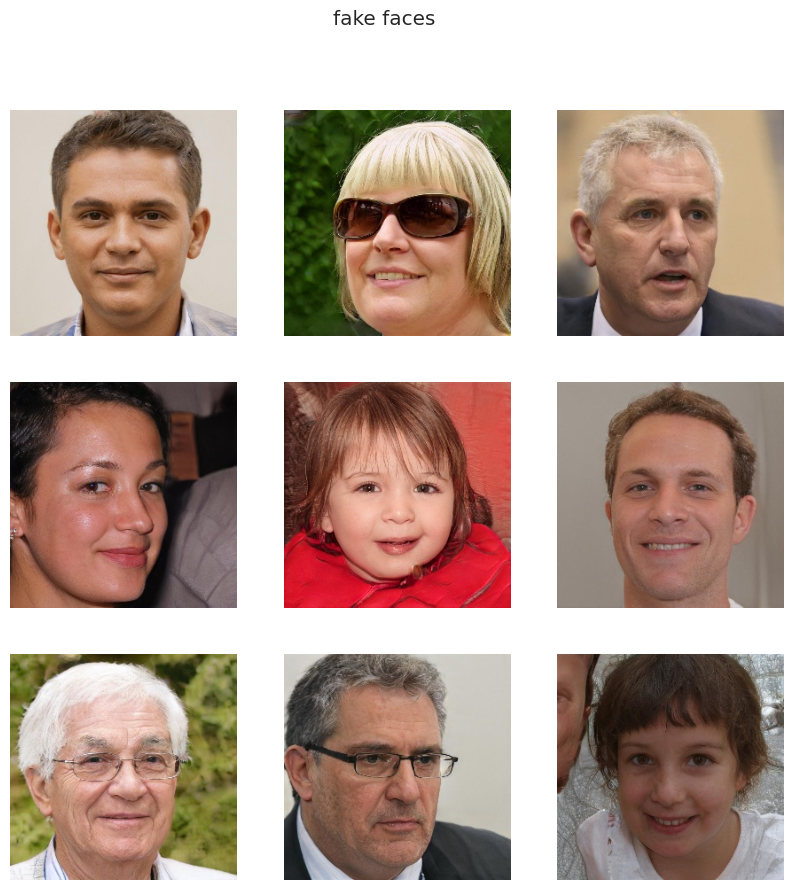

In [7]:
plot_img(path, 'fake')

## Creating the testing and training data

In [8]:
real_dir = os.path.join(path, 'train', 'real')
fake_dir = os.path.join(path, 'train', 'fake')

In [9]:
def load_img_path(directory, label):
    """
    returns nested list containing image path and label
    """
    data = []
    for filename in os.listdir(directory):

        img_path = os.path.join(directory, filename)
        data.append([img_path, label])
    return data

In [10]:
real_train_data = load_img_path(os.path.join(path, 'train', 'real'), 'real')
fake_train_data = load_img_path(os.path.join(path, 'train', 'fake'), 'fake')
# load the image paths and labels onto a dataframe
df = pd.DataFrame(data=real_train_data + fake_train_data, columns=['image', 'label'])


In [11]:
df.head()

image label
0  ../input/140k-real-and-fake-faces/real_vs_fake...  real
1  ../input/140k-real-and-fake-faces/real_vs_fake...  real
2  ../input/140k-real-and-fake-faces/real_vs_fake...  real
3  ../input/140k-real-and-fake-faces/real_vs_fake...  real
4  ../input/140k-real-and-fake-faces/real_vs_fake...  real

In [12]:
df.tail()

image label
99995  ../input/140k-real-and-fake-faces/real_vs_fake...  fake
99996  ../input/140k-real-and-fake-faces/real_vs_fake...  fake
99997  ../input/140k-real-and-fake-faces/real_vs_fake...  fake
99998  ../input/140k-real-and-fake-faces/real_vs_fake...  fake
99999  ../input/140k-real-and-fake-faces/real_vs_fake...  fake

In [13]:
def show_images(gen):
    # Get the class names and a batch of images and labels from the generator
    classes = list(gen.class_indices.keys())
    print(classes)
    images, labels = next(gen)
    
    # Calculate the number of images to display
    num_images = min(len(labels), 16)
    
    # Plot the images and their labels
    fig, axes = plt.subplots(nrows=8, ncols=8, figsize=(8, 8))
    for i, ax in enumerate(axes.flat):
        if i < num_images:
            ax.imshow(images[i])
            label_index = np.argmax(labels[i])
            ax.set_title(classes[label_index])
            ax.axis('off')
        else:
            ax.axis('off')
    
    plt.tight_layout()
    plt.show()

In [14]:
def plot_training(hist):
    """
    visualize the training and validation performance of a machine learning model over epochs. 
    It plots two subplots
    1.training and validation loss 
    2. training and validation accuracy, 
    highlighting the epochs with the lowest validation loss and the highest validation accuracy
    """
    tr_acc = hist.history['accuracy']
    tr_loss = hist.history['loss']
    val_acc = hist.history['val_accuracy']
    val_loss = hist.history['val_loss']
    index_loss = np.argmin(val_loss)
    val_lowest = val_loss[index_loss]
    index_acc = np.argmax(val_acc)
    acc_highest = val_acc[index_acc]

    plt.figure(figsize= (20, 8))
    plt.style.use('fivethirtyeight')
    Epochs = [i+1 for i in range(len(tr_acc))]
    loss_label = f'best epoch= {str(index_loss + 1)}'
    acc_label = f'best epoch= {str(index_acc + 1)}'
    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
    plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
    plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
    plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.tight_layout
    plt.show()
    

In [15]:
## splitting the dataset into train and test datasets

In [16]:
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)

In [17]:
train_df.head()

image label
54843  ../input/140k-real-and-fake-faces/real_vs_fake...  fake
96606  ../input/140k-real-and-fake-faces/real_vs_fake...  fake
65990  ../input/140k-real-and-fake-faces/real_vs_fake...  fake
5772   ../input/140k-real-and-fake-faces/real_vs_fake...  real
66546  ../input/140k-real-and-fake-faces/real_vs_fake...  fake

In [18]:
test_df.head()

image label
46192  ../input/140k-real-and-fake-faces/real_vs_fake...  real
95838  ../input/140k-real-and-fake-faces/real_vs_fake...  fake
91913  ../input/140k-real-and-fake-faces/real_vs_fake...  fake
33243  ../input/140k-real-and-fake-faces/real_vs_fake...  real
73864  ../input/140k-real-and-fake-faces/real_vs_fake...  fake

In [19]:
train_datagen = image.ImageDataGenerator(rescale= 1./255,  horizontal_flip = True)
val_test_datagen = image.ImageDataGenerator(rescale=1./255)

batch_size = 64
target_size = (256, 256)

# Define the train and test generators
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='image',
    y_col='label',
    class_mode='binary',
    shuffle=True,
    batch_size=batch_size,
    target_size=target_size,
    subset='training'
)

test_generator = val_test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='image',
    y_col='label',
    shuffle=False,
    class_mode='binary',
    batch_size=batch_size,
    target_size=target_size
)

Found 80000 validated image filenames belonging to 2 classes.
Found 20000 validated image filenames belonging to 2 classes.


['fake', 'real']


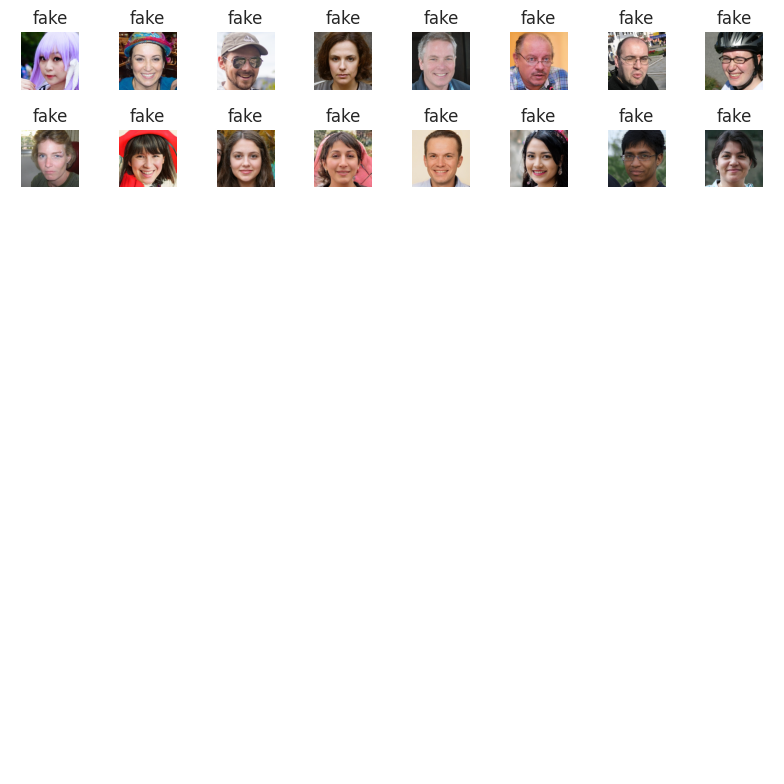

In [20]:
show_images(train_generator)

## Model Structure

In [21]:
# Create Model Structure
img_size = (256, 256)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_generator.class_indices.keys())) # to define number of classes in dense layer

base_model = Xception(include_top= False, weights= "imagenet", input_shape= img_shape)

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(512, activation = 'relu'),
    BatchNormalization(),
    Dropout(0.2),
    Dense(1, activation = 'sigmoid')
])

model.compile(optimizer="sgd", loss= 'binary_crossentropy', metrics= ['accuracy'])

model.summary()

83683744/83683744 [==============================] - 4s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 8, 8, 2048)        20861480  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 batch_normalization_4 (Batc  (None, 512)              2048      
 hNormalization)                                                 
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                         

## Model Training

In [22]:


early_stopping_callbacks =EarlyStopping(monitor='val_loss',patience = 4, restore_best_weights = True, verbose = 1)

history = model.fit(train_generator,
    validation_data=test_generator,
    epochs=10,
    steps_per_epoch = 100,
    callbacks = [early_stopping_callbacks])

Epoch 1/10
100/100 [==============================] - 265s 2s/step - loss: 0.5749 - accuracy: 0.7123 - val_loss: 0.6350 - val_accuracy: 0.5908
Epoch 2/10
100/100 [==============================] - 141s 1s/step - loss: 0.3685 - accuracy: 0.8372 - val_loss: 0.4140 - val_accuracy: 0.8644
Epoch 3/10
100/100 [==============================] - 141s 1s/step - loss: 0.2755 - accuracy: 0.8855 - val_loss: 0.2865 - val_accuracy: 0.8979
Epoch 4/10
100/100 [==============================] - 139s 1s/step - loss: 0.2132 - accuracy: 0.9162 - val_loss: 0.1970 - val_accuracy: 0.9286
Epoch 5/10
100/100 [==============================] - 144s 1s/step - loss: 0.1706 - accuracy: 0.9309 - val_loss: 0.1501 - val_accuracy: 0.9419
Epoch 6/10
100/100 [==============================] - 142s 1s/step - loss: 0.1515 - accuracy: 0.9419 - val_loss: 0.1296 - val_accuracy: 0.9499
Epoch 7/10
100/100 [==============================] - 142s 1s/step - loss: 0.1214 - accuracy: 0.9531 - val_loss: 0.1098 - val_accuracy: 0.9578

## Model Evaluation

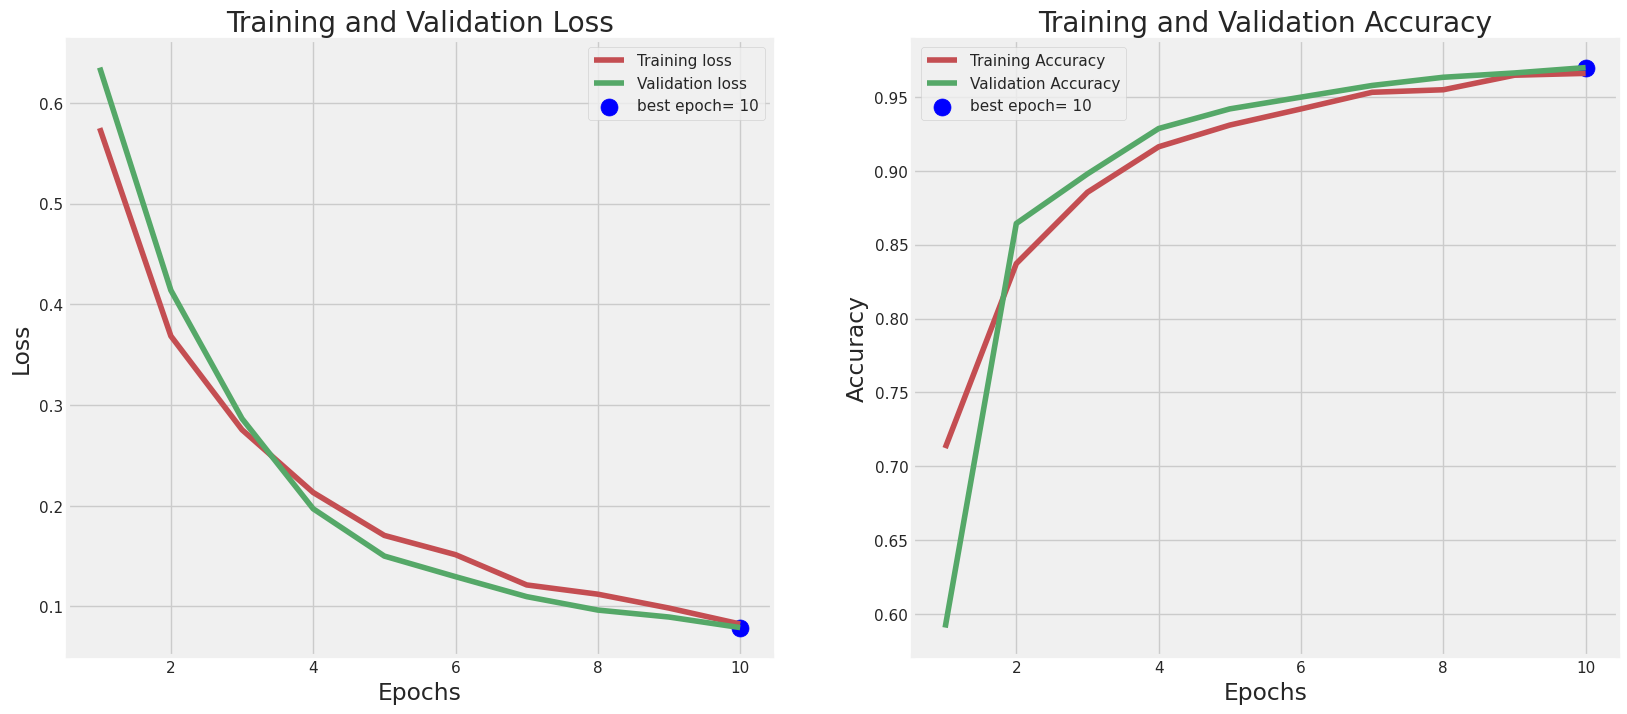

In [23]:
plot_training(history)


In [24]:
predicted_labels = model.predict(test_generator)
true_labels = test_generator.classes


313/313 [==============================] - 73s 231ms/step


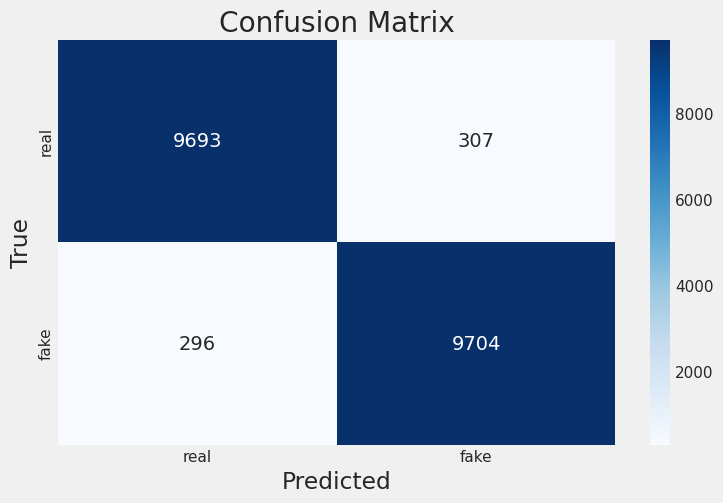

In [25]:

plt.figure(figsize = (8,5))
sn.heatmap(confusion_matrix(true_labels, predicted_labels.round()), annot = True,fmt="d",cmap = "Blues", xticklabels=['real', 'fake'], yticklabels=['real', 'fake'])

# Add labels and title
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [26]:
y_pred = predicted_labels.round()

In [27]:
print(classification_report(test_generator.classes,y_pred,  target_names= ['fake', 'real'] ))

              precision    recall  f1-score   support

        fake       0.97      0.97      0.97     10000
        real       0.97      0.97      0.97     10000

    accuracy                           0.97     20000
   macro avg       0.97      0.97      0.97     20000
weighted avg       0.97      0.97      0.97     20000



In [28]:
model.save('/kaggle/working/xceptionmodel.h5')

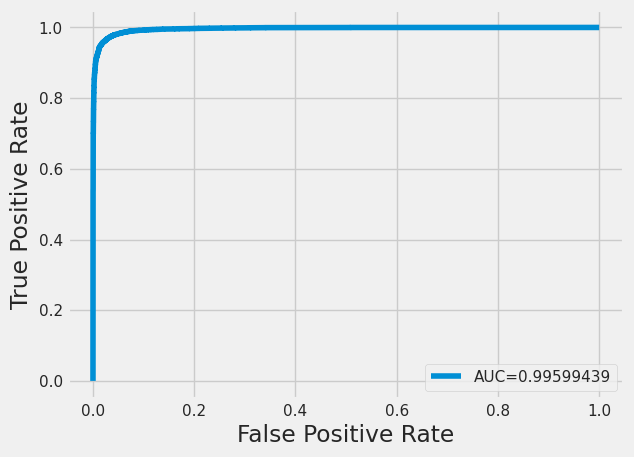

In [29]:
fpr, tpr, _ = metrics.roc_curve(true_labels,  predicted_labels)
auc = metrics.roc_auc_score(true_labels, predicted_labels)

#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

## Running Inference on random Images

1/1 [==============================] - 1s 903ms/step


Text(0.5, 1.0, 'This image is 0.10% Fake and 99.90% Real.')

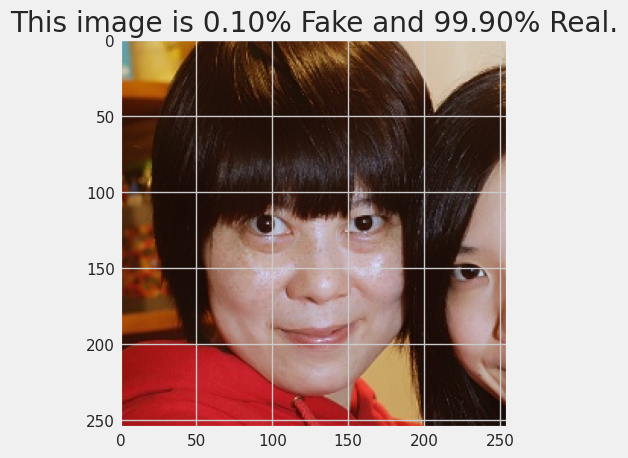

In [30]:
test_image = image.load_img('/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/valid/real/00008.jpg', target_size=(256, 256, 3))
plt.imshow(test_image)
test_image_arr = image.img_to_array(test_image)
test_image_arr = np.expand_dims(test_image, axis=0)
test_image_arr = test_image_arr/255.


result = model.predict(test_image_arr)

plt.title(f"This image is {100 * (1 - result[0][0]):.2f}% Fake and {100 * result[0][0]:.2f}% Real.")

1/1 [==============================] - 0s 22ms/step


Text(0.5, 1.0, 'This image is 58.69% Fake and 41.31% Real.')

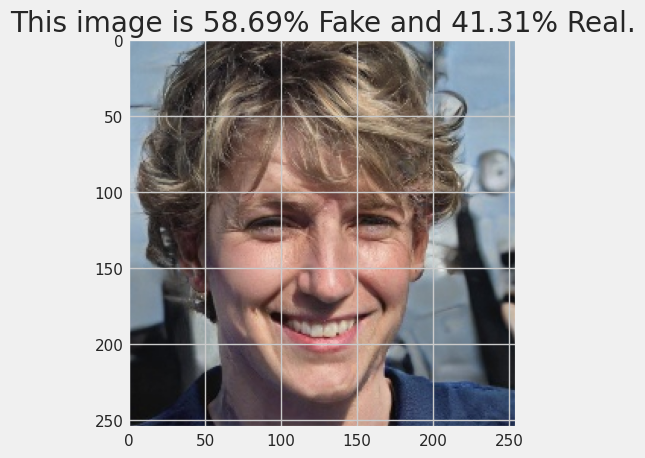

In [31]:
test_image = image.load_img('/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/valid/fake/007SMMOPYB.jpg', target_size=(256, 256, 3))
plt.imshow(test_image)
test_image_arr = image.img_to_array(test_image)
test_image_arr = np.expand_dims(test_image, axis=0)
test_image_arr = test_image_arr/255.


result = model.predict(test_image_arr)

plt.title(f"This image is {100 * (1 - result[0][0]):.2f}% Fake and {100 * result[0][0]:.2f}% Real.")

1/1 [==============================] - 0s 20ms/step


Text(0.5, 1.0, 'This image is 0.40% Fake and 99.60% Real.')

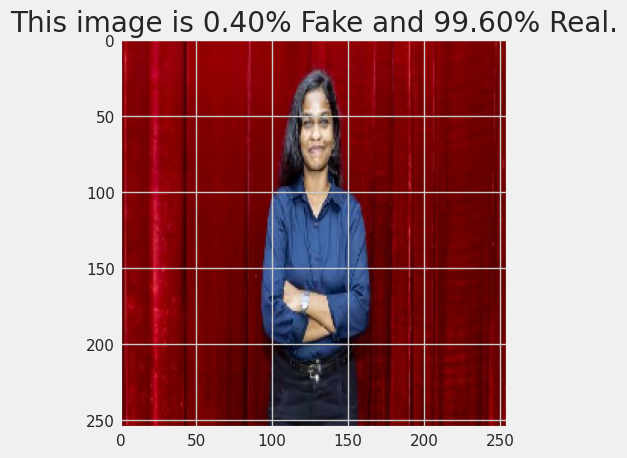

In [39]:
test_image = image.load_img('/kaggle/input/humans/for_purpose.jpg', target_size=(256, 256, 3))
plt.imshow(test_image)
test_image_arr = image.img_to_array(test_image)
test_image_arr = np.expand_dims(test_image, axis=0)
test_image_arr = test_image_arr/255.


result = model.predict(test_image_arr)

plt.title(f"This image is {100 * (1 - result[0][0]):.2f}% Fake and {100 * result[0][0]:.2f}% Real.")

1/1 [==============================] - 0s 21ms/step


Text(0.5, 1.0, 'This image is 0.86% Fake and 99.14% Real.')

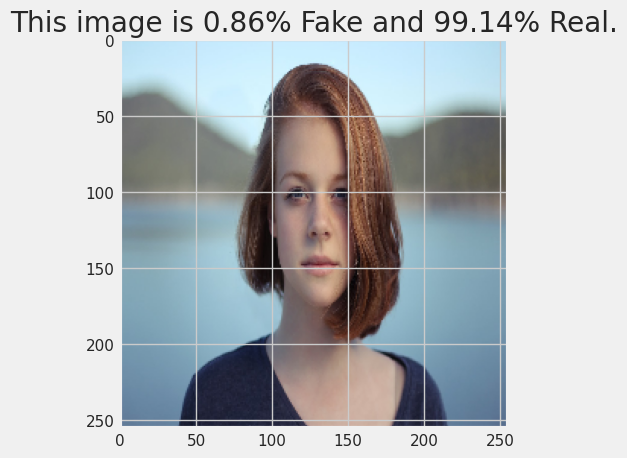

In [33]:
test_image = image.load_img('/kaggle/input/humans/WhatsApp Image 2023-10-15 at 16.16.18_c17d7f99.jpg', target_size=(256, 256, 3))
plt.imshow(test_image)
test_image_arr = image.img_to_array(test_image)
test_image_arr = np.expand_dims(test_image, axis=0)
test_image_arr = test_image_arr/255.


result = model.predict(test_image_arr)

plt.title(f"This image is {100 * (1 - result[0][0]):.2f}% Fake and {100 * result[0][0]:.2f}% Real.")

1/1 [==============================] - 0s 21ms/step


Text(0.5, 1.0, 'This image is 0.22% Fake and 99.78% Real.')

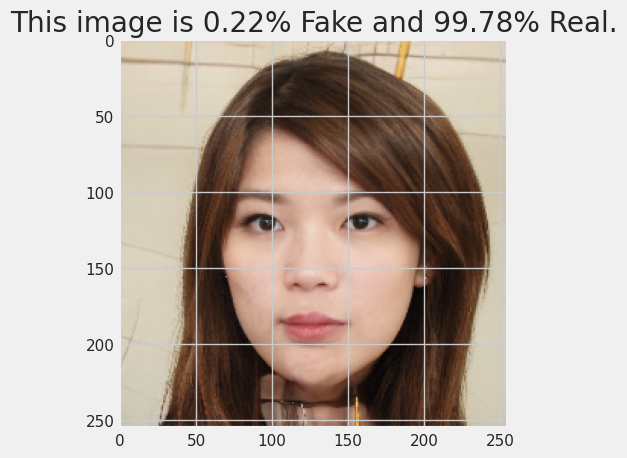

In [34]:
test_image = image.load_img('/kaggle/input/humanssss/download (3).jpeg', target_size=(256, 256, 3))
plt.imshow(test_image)
test_image_arr = image.img_to_array(test_image)
test_image_arr = np.expand_dims(test_image, axis=0)
test_image_arr = test_image_arr/255.


result = model.predict(test_image_arr)

plt.title(f"This image is {100 * (1 - result[0][0]):.2f}% Fake and {100 * result[0][0]:.2f}% Real.")

1/1 [==============================] - 0s 21ms/step


Text(0.5, 1.0, 'This image is 83.58% Fake and 16.42% Real.')

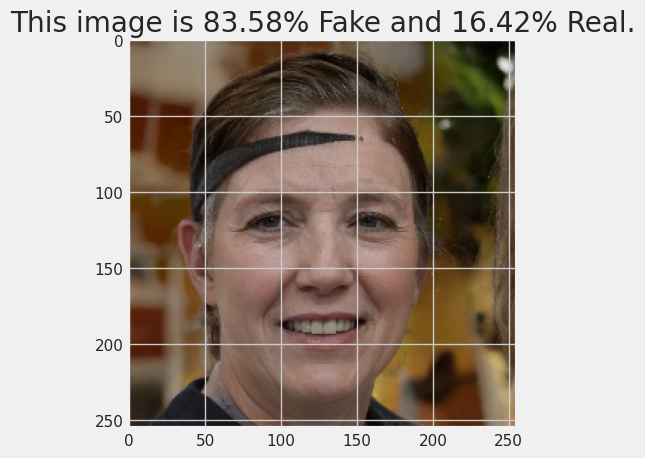

In [35]:
test_image = image.load_img('/kaggle/input/againnn/download (4).jpeg', target_size=(256, 256, 3))
plt.imshow(test_image)
test_image_arr = image.img_to_array(test_image)
test_image_arr = np.expand_dims(test_image, axis=0)
test_image_arr = test_image_arr/255.


result = model.predict(test_image_arr)

plt.title(f"This image is {100 * (1 - result[0][0]):.2f}% Fake and {100 * result[0][0]:.2f}% Real.")

1/1 [==============================] - 0s 22ms/step


Text(0.5, 1.0, 'This image is 92.70% Fake and 7.30% Real.')

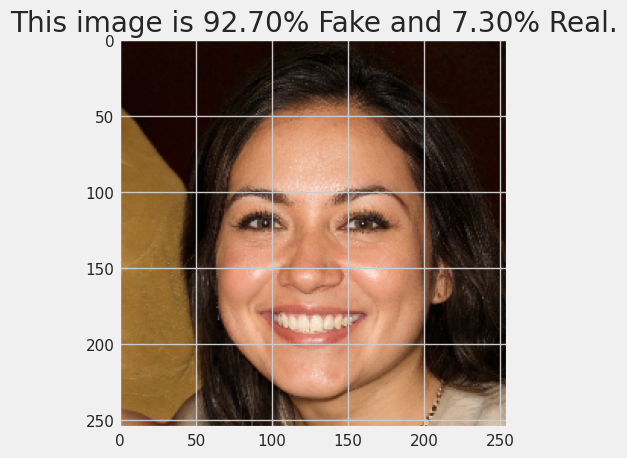

In [36]:
test_image = image.load_img('/kaggle/input/tryyyy/download (5).jpeg', target_size=(256, 256, 3))
plt.imshow(test_image)
test_image_arr = image.img_to_array(test_image)
test_image_arr = np.expand_dims(test_image, axis=0)
test_image_arr = test_image_arr/255.


result = model.predict(test_image_arr)

plt.title(f"This image is {100 * (1 - result[0][0]):.2f}% Fake and {100 * result[0][0]:.2f}% Real.")

1/1 [==============================] - 0s 34ms/step


Text(0.5, 1.0, 'This image is 0.18% Fake and 99.82% Real.')

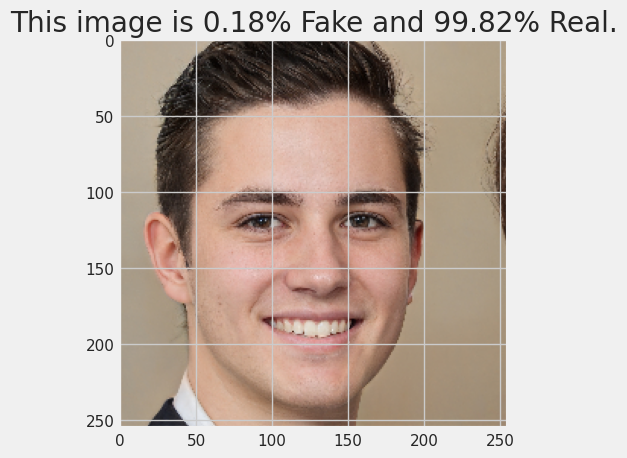

In [37]:
test_image = image.load_img('/kaggle/input/tryyyy/download (6).jpeg', target_size=(256, 256, 3))
plt.imshow(test_image)
test_image_arr = image.img_to_array(test_image)
test_image_arr = np.expand_dims(test_image, axis=0)
test_image_arr = test_image_arr/255.


result = model.predict(test_image_arr)

plt.title(f"This image is {100 * (1 - result[0][0]):.2f}% Fake and {100 * result[0][0]:.2f}% Real.")

1/1 [==============================] - 0s 23ms/step


Text(0.5, 1.0, 'This image is 88.27% Fake and 11.73% Real.')

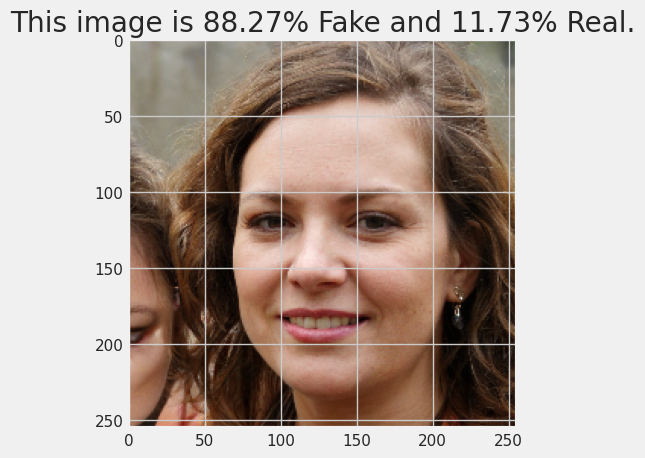

In [38]:
test_image = image.load_img('/kaggle/input/tryyyy/download (7).jpeg', target_size=(256, 256, 3))
plt.imshow(test_image)
test_image_arr = image.img_to_array(test_image)
test_image_arr = np.expand_dims(test_image, axis=0)
test_image_arr = test_image_arr/255.


result = model.predict(test_image_arr)

plt.title(f"This image is {100 * (1 - result[0][0]):.2f}% Fake and {100 * result[0][0]:.2f}% Real.")

1/1 [==============================] - 0s 23ms/step


Text(0.5, 1.0, 'This image is 0.05% Fake and 99.95% Real.')

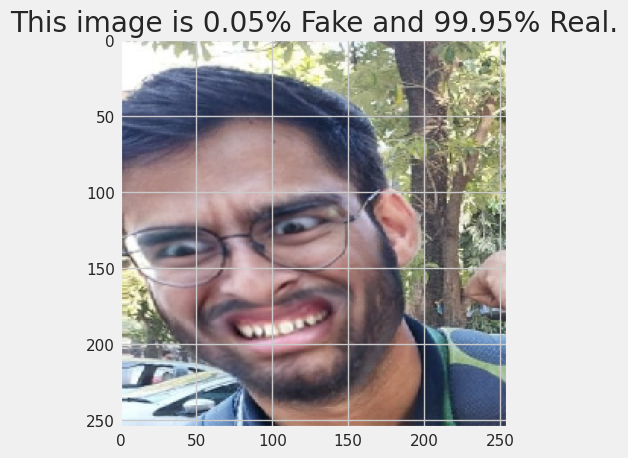

In [40]:
test_image = image.load_img('/kaggle/input/hhhhhhh/WhatsApp Image 2023-10-15 at 20.11.50_0ceb02a1.jpg', target_size=(256, 256, 3))
plt.imshow(test_image)
test_image_arr = image.img_to_array(test_image)
test_image_arr = np.expand_dims(test_image, axis=0)
test_image_arr = test_image_arr/255.


result = model.predict(test_image_arr)

plt.title(f"This image is {100 * (1 - result[0][0]):.2f}% Fake and {100 * result[0][0]:.2f}% Real.")

1/1 [==============================] - 0s 21ms/step


Text(0.5, 1.0, 'This image is 0.01% Fake and 99.99% Real.')

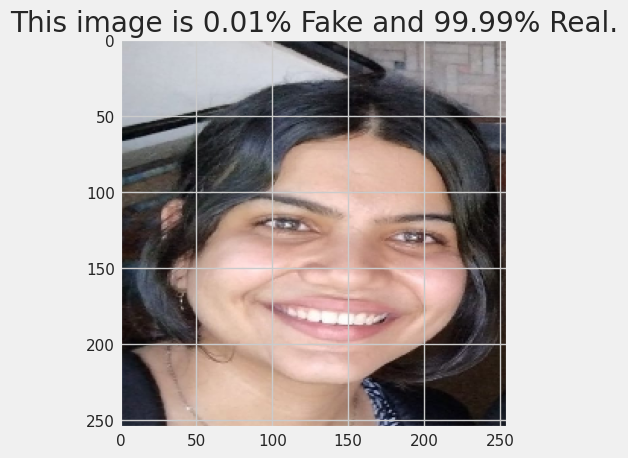

In [41]:
test_image = image.load_img('/kaggle/input/vosttttttt/WhatsApp Image 2023-10-15 at 20.17.39_af809fc8.jpg', target_size=(256, 256, 3))
plt.imshow(test_image)
test_image_arr = image.img_to_array(test_image)
test_image_arr = np.expand_dims(test_image, axis=0)
test_image_arr = test_image_arr/255.


result = model.predict(test_image_arr)

plt.title(f"This image is {100 * (1 - result[0][0]):.2f}% Fake and {100 * result[0][0]:.2f}% Real.")

1/1 [==============================] - 0s 21ms/step


Text(0.5, 1.0, 'This image is 0.00% Fake and 100.00% Real.')

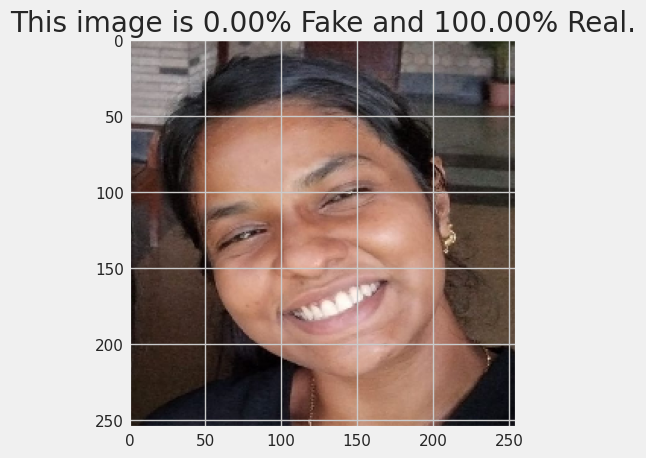

In [42]:
test_image = image.load_img('/kaggle/input/vosttttttt/WhatsApp Image 2023-10-15 at 20.17.40_bfa7e149.jpg', target_size=(256, 256, 3))
plt.imshow(test_image)
test_image_arr = image.img_to_array(test_image)
test_image_arr = np.expand_dims(test_image, axis=0)
test_image_arr = test_image_arr/255.


result = model.predict(test_image_arr)

plt.title(f"This image is {100 * (1 - result[0][0]):.2f}% Fake and {100 * result[0][0]:.2f}% Real.")

1/1 [==============================] - 0s 26ms/step


Text(0.5, 1.0, 'This image is 0.00% Fake and 100.00% Real.')

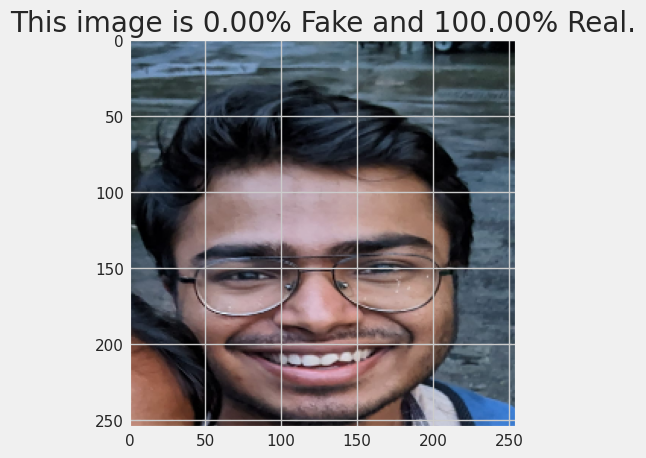

In [43]:
test_image = image.load_img('/kaggle/input/fakebois/WhatsApp Image 2023-10-15 at 20.21.21_a7c15a0f.jpg', target_size=(256, 256, 3))
plt.imshow(test_image)
test_image_arr = image.img_to_array(test_image)
test_image_arr = np.expand_dims(test_image, axis=0)
test_image_arr = test_image_arr/255.


result = model.predict(test_image_arr)

plt.title(f"This image is {100 * (1 - result[0][0]):.2f}% Fake and {100 * result[0][0]:.2f}% Real.")

1/1 [==============================] - 0s 21ms/step


Text(0.5, 1.0, 'This image is 1.56% Fake and 98.44% Real.')

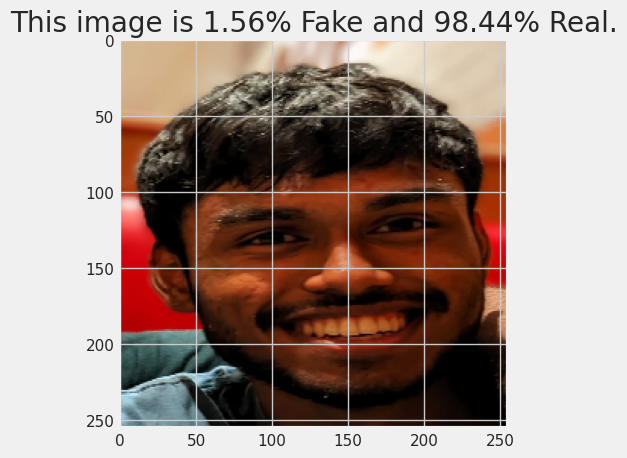

In [44]:
test_image = image.load_img('/kaggle/input/fakebois/WhatsApp Image 2023-10-15 at 20.22.58_2982e592.jpg', target_size=(256, 256, 3))
plt.imshow(test_image)
test_image_arr = image.img_to_array(test_image)
test_image_arr = np.expand_dims(test_image, axis=0)
test_image_arr = test_image_arr/255.


result = model.predict(test_image_arr)

plt.title(f"This image is {100 * (1 - result[0][0]):.2f}% Fake and {100 * result[0][0]:.2f}% Real.")

1/1 [==============================] - 0s 21ms/step


Text(0.5, 1.0, 'This image is 0.26% Fake and 99.74% Real.')

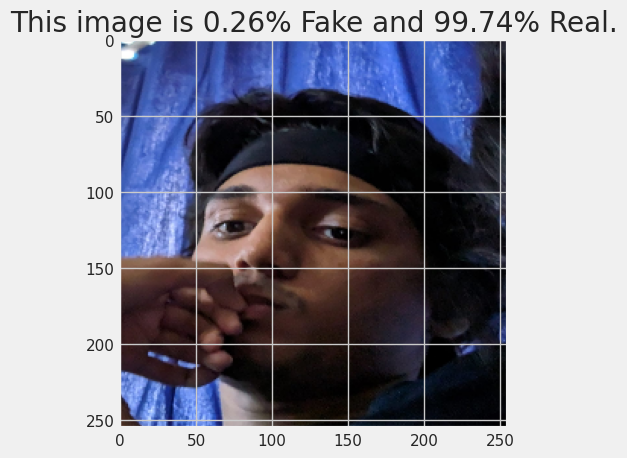

In [45]:
test_image = image.load_img('/kaggle/input/fakebois/WhatsApp Image 2023-10-15 at 20.23.43_9337b9c4.jpg', target_size=(256, 256, 3))
plt.imshow(test_image)
test_image_arr = image.img_to_array(test_image)
test_image_arr = np.expand_dims(test_image, axis=0)
test_image_arr = test_image_arr/255.


result = model.predict(test_image_arr)

plt.title(f"This image is {100 * (1 - result[0][0]):.2f}% Fake and {100 * result[0][0]:.2f}% Real.")

1/1 [==============================] - 0s 23ms/step


Text(0.5, 1.0, 'This image is 0.13% Fake and 99.87% Real.')

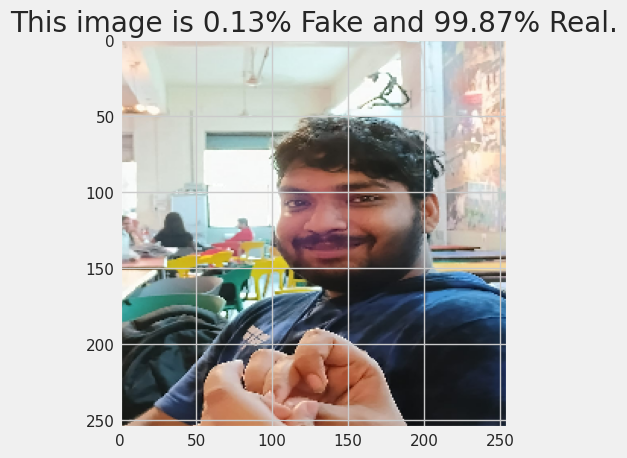

In [46]:
test_image = image.load_img('/kaggle/input/fakebois/WhatsApp Image 2023-10-15 at 20.23.56_14c06066.jpg', target_size=(256, 256, 3))
plt.imshow(test_image)
test_image_arr = image.img_to_array(test_image)
test_image_arr = np.expand_dims(test_image, axis=0)
test_image_arr = test_image_arr/255.


result = model.predict(test_image_arr)

plt.title(f"This image is {100 * (1 - result[0][0]):.2f}% Fake and {100 * result[0][0]:.2f}% Real.")

1/1 [==============================] - 0s 21ms/step


Text(0.5, 1.0, 'This image is 0.01% Fake and 99.99% Real.')

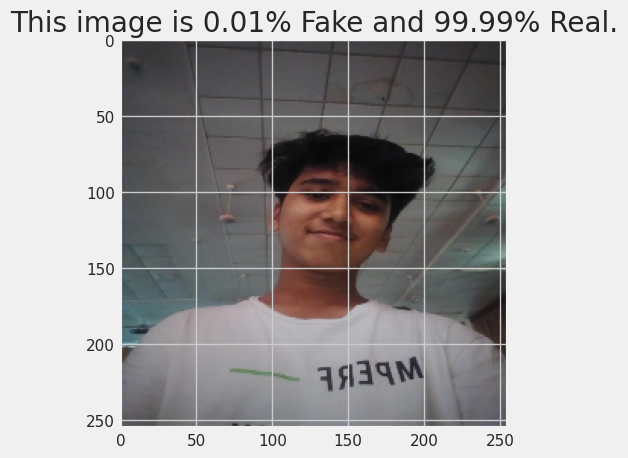

In [47]:
test_image = image.load_img('/kaggle/input/fakebois/WhatsApp Image 2023-10-15 at 20.24.29_d77e24a0.jpg', target_size=(256, 256, 3))
plt.imshow(test_image)
test_image_arr = image.img_to_array(test_image)
test_image_arr = np.expand_dims(test_image, axis=0)
test_image_arr = test_image_arr/255.


result = model.predict(test_image_arr)

plt.title(f"This image is {100 * (1 - result[0][0]):.2f}% Fake and {100 * result[0][0]:.2f}% Real.")

1/1 [==============================] - 0s 21ms/step


Text(0.5, 1.0, 'This image is 0.02% Fake and 99.98% Real.')

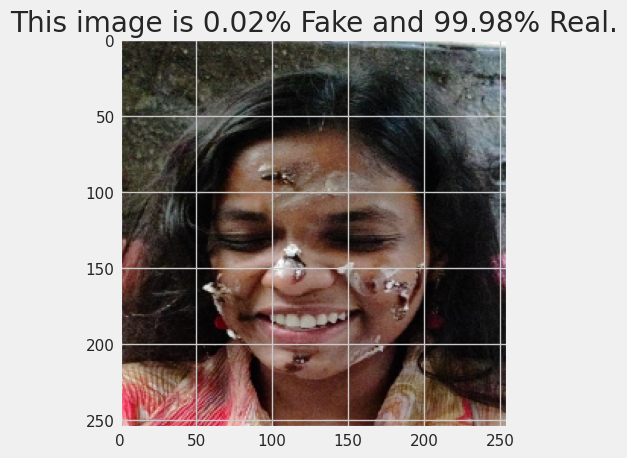

In [48]:
test_image = image.load_img('/kaggle/input/fakebois/WhatsApp Image 2023-10-15 at 20.25.09_8e2107ed.jpg', target_size=(256, 256, 3))
plt.imshow(test_image)
test_image_arr = image.img_to_array(test_image)
test_image_arr = np.expand_dims(test_image, axis=0)
test_image_arr = test_image_arr/255.


result = model.predict(test_image_arr)

plt.title(f"This image is {100 * (1 - result[0][0]):.2f}% Fake and {100 * result[0][0]:.2f}% Real.")

1/1 [==============================] - 0s 21ms/step


Text(0.5, 1.0, 'This image is 0.01% Fake and 99.99% Real.')

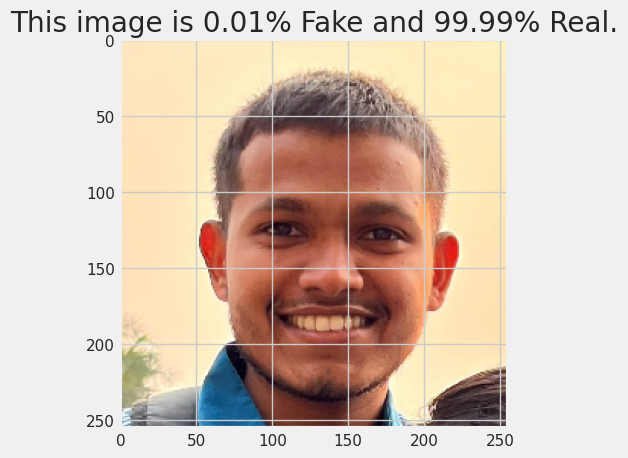

In [49]:
test_image = image.load_img('/kaggle/input/fakebois/WhatsApp Image 2023-10-15 at 20.25.24_078db54b.jpg', target_size=(256, 256, 3))
plt.imshow(test_image)
test_image_arr = image.img_to_array(test_image)
test_image_arr = np.expand_dims(test_image, axis=0)
test_image_arr = test_image_arr/255.


result = model.predict(test_image_arr)

plt.title(f"This image is {100 * (1 - result[0][0]):.2f}% Fake and {100 * result[0][0]:.2f}% Real.")

1/1 [==============================] - 0s 22ms/step


Text(0.5, 1.0, 'This image is 0.01% Fake and 99.99% Real.')

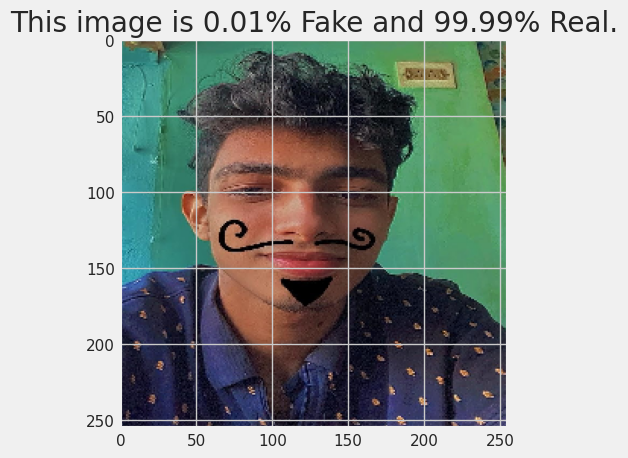

In [50]:
test_image = image.load_img('/kaggle/input/fakebois/WhatsApp Image 2023-10-15 at 20.25.57_4cab8cf7.jpg', target_size=(256, 256, 3))
plt.imshow(test_image)
test_image_arr = image.img_to_array(test_image)
test_image_arr = np.expand_dims(test_image, axis=0)
test_image_arr = test_image_arr/255.


result = model.predict(test_image_arr)

plt.title(f"This image is {100 * (1 - result[0][0]):.2f}% Fake and {100 * result[0][0]:.2f}% Real.")

1/1 [==============================] - 0s 21ms/step


Text(0.5, 1.0, 'This image is 0.02% Fake and 99.98% Real.')

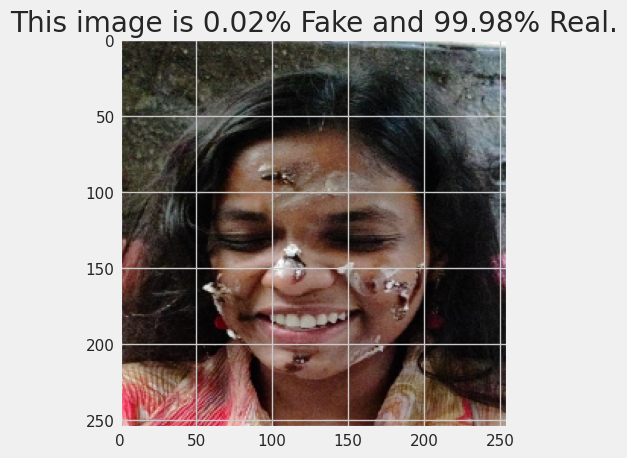

In [51]:
test_image = image.load_img('/kaggle/input/fakebois/WhatsApp Image 2023-10-15 at 20.25.09_8e2107ed.jpg', target_size=(256, 256, 3))
plt.imshow(test_image)
test_image_arr = image.img_to_array(test_image)
test_image_arr = np.expand_dims(test_image, axis=0)
test_image_arr = test_image_arr/255.


result = model.predict(test_image_arr)

plt.title(f"This image is {100 * (1 - result[0][0]):.2f}% Fake and {100 * result[0][0]:.2f}% Real.")